In [1]:
import fastf1 as f1
import fastf1.plotting
import matplotlib.pyplot as plt
import numpy as np
fastf1.plotting.setup_mpl()
import datetime
import os


fastf1.Cache.enable_cache(os.getcwd())

In [2]:
now = datetime.date.today().strftime('%Y-%m-%d')
print(f"The date today is: {now}\nThe races that have already happened are the following:")
schedule = f1.get_event_schedule(2024)
schedule_to_date = schedule[schedule.EventDate<now]
schedule_to_date = schedule_to_date[schedule_to_date.RoundNumber>0]
print(f"{schedule_to_date[['Location','EventDate']].to_string(index=False, header=False)}")
n=max(schedule_to_date['RoundNumber'])+1
print(f"---Next Race---\n{schedule.Location.loc[n]} {schedule.EventDate.loc[n].strftime('%Y-%m-%d')}")

The date today is: 2024-10-01
The races that have already happened are the following:
           Sakhir 2024-03-02
           Jeddah 2024-03-09
        Melbourne 2024-03-24
           Suzuka 2024-04-07
         Shanghai 2024-04-21
            Miami 2024-05-05
            Imola 2024-05-19
           Monaco 2024-05-26
         Montréal 2024-06-09
        Barcelona 2024-06-23
        Spielberg 2024-06-30
      Silverstone 2024-07-07
         Budapest 2024-07-21
Spa-Francorchamps 2024-07-28
        Zandvoort 2024-08-25
            Monza 2024-09-01
             Baku 2024-09-15
       Marina Bay 2024-09-22
---Next Race---
Austin 2024-10-20


In [3]:
session_name='Marina Bay'

session = f1.get_session(2024,session_name, 'Race')
session.load(telemetry=False, weather=False)

core           INFO 	Loading data for Singapore Grand Prix - Race [v3.3.5]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No 

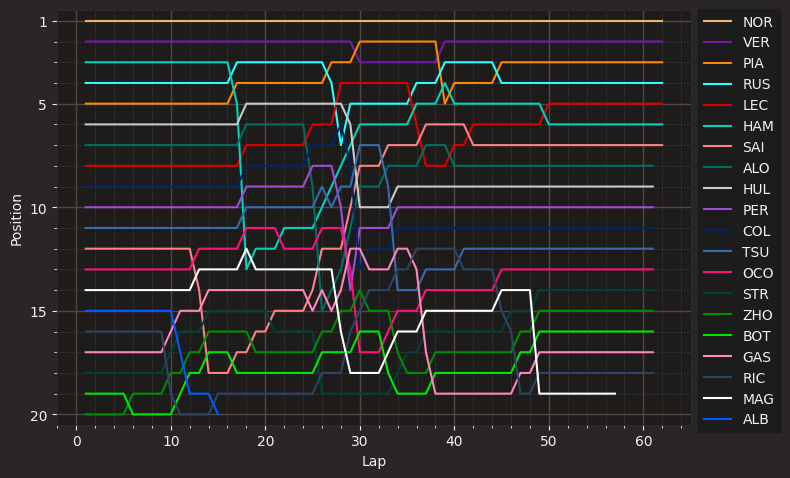

In [4]:
## Here we are going to plot position changes during Suzuka
fastf1.plotting.setup_mpl(misc_mpl_mods=False)

fig,ax=plt.subplots(figsize=(8,4.9))
for driver in session.drivers:
    driver_laps = session.laps.pick_driver(driver)
    name_abbr = driver_laps['Driver'].iloc[0] ## 3 lettername abbreviation in laps format
    color= fastf1.plotting.driver_color(name_abbr)
    ax.plot(driver_laps['LapNumber'], driver_laps['Position'], label=name_abbr, color=color)

ax.set_ylim([20.5, 0.5])
ax.set_yticks([1, 5, 10, 15, 20])
ax.set_xlabel('Lap')
ax.set_ylabel('Position')

ax.legend(bbox_to_anchor=(1.0, 1.02))
plt.tight_layout()

plt.show()


In [5]:

session.total_laps

51

In [5]:
## Get and organize lap stint data
all_laps=session.laps
drivers=session.drivers
drivers=[session.get_driver(drvr)["Abbreviation"] for drvr in drivers] # get abbr

finishing_order = [session.get_driver(i)["Abbreviation"] for i in session.drivers]

stints = all_laps[["Driver", "Stint", "Compound", "LapNumber"]] # only data we are curious in
stints = stints.groupby(["Driver", "Stint", "Compound"]) # group first by driver, then by stint, then by compound
stints = stints.count().reset_index() # replace index with length of stints
stints = stints.rename(columns={"LapNumber":"StintLength"}) # change index header to new name

In [6]:
print(finishing_order)

['NOR', 'VER', 'PIA', 'RUS', 'LEC', 'HAM', 'SAI', 'ALO', 'HUL', 'PER', 'COL', 'TSU', 'OCO', 'STR', 'ZHO', 'BOT', 'GAS', 'RIC', 'MAG', 'ALB']


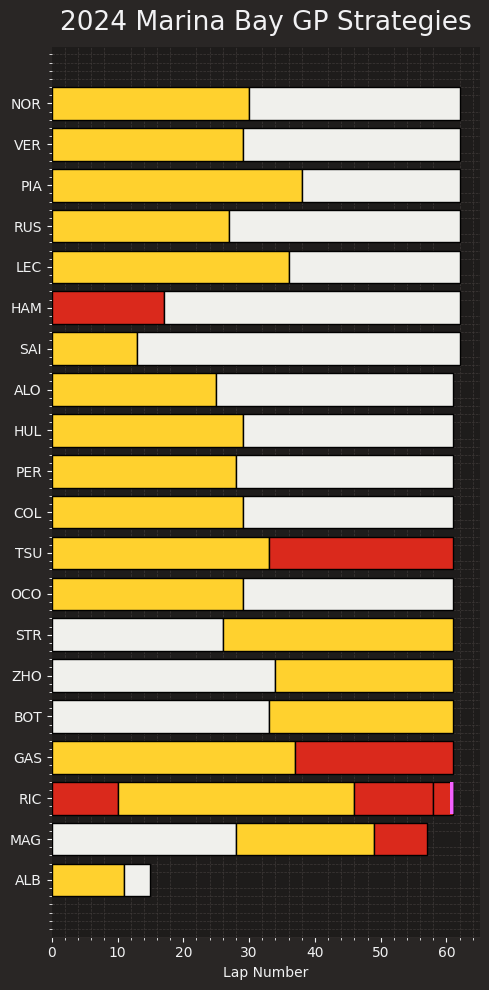

In [7]:
fix, ax=plt.subplots(figsize=(5,10))
for driver in drivers:
    driver_stints = stints.loc[stints["Driver"]==driver]
    prev_stint_end=0

    for idx, row in driver_stints.iterrows():
        #plt stacked bar horizontally
        plt.barh(y=driver, 
                    width=row["StintLength"], 
                    left=prev_stint_end, 
                    color=fastf1.plotting.COMPOUND_COLORS[row["Compound"]], #tirecolor
                    edgecolor="black", 
                    fill=True)
        prev_stint_end+=row["StintLength"]
plt.title(f"2024 {session_name} GP Strategies")
plt.xlabel("Lap Number")
plt.grid(False)
text_y = finishing_order.index(all_laps.pick_fastest()['Driver'])
plt.text(x=all_laps.pick_fastest()['LapNumber'], y=text_y+0.2, s="|", fontsize=23, fontweight='bold', color='#F461FF')

ax.invert_yaxis() # invert y-axis so drivers that finish higher are closer to the top
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.tight_layout()
plt.show()

In [8]:
## Laptime Distribution ##
all_driver_laps = session.laps.pick_drivers(drivers).pick_quicklaps()
all_driver_laps = all_driver_laps.reset_index()
driver_colors = {abv: fastf1.plotting.DRIVER_COLORS[driver] for abv,
                 driver in fastf1.plotting.DRIVER_TRANSLATE.items()}
driver_colors['COL']="#012564"
results=session.results[['Abbreviation', 'ClassifiedPosition']]
results['Abbreviation']

4     NOR
1     VER
81    PIA
63    RUS
16    LEC
44    HAM
55    SAI
14    ALO
27    HUL
11    PER
43    COL
22    TSU
31    OCO
18    STR
24    ZHO
77    BOT
10    GAS
3     RIC
20    MAG
23    ALB
Name: Abbreviation, dtype: object

In [11]:
driver_colors

{'LEC': '#dc0000',
 'SAI': '#ff8181',
 'SHW': '#9c0000',
 'VER': '#721aaa',
 'PER': '#a14cd6',
 'DEN': '#907400',
 'PIA': '#ff8700',
 'NOR': '#eeb370',
 'OWA': '#ee6d3a',
 'GAS': '#fe86bc',
 'OCO': '#ff117c',
 'DOO': '#894667',
 'BOT': '#00e701',
 'ZHO': '#008d01',
 'POU': '#004601',
 'DEV': '#1e3d61',
 'TSU': '#356cac',
 'RIC': '#2b4562',
 'LAW': '#2b4562',
 'HAD': '#1e6176',
 'IWA': '#1e6176',
 'MAG': '#ffffff',
 'HUL': '#cacaca',
 'BEA': '#c40000',
 'ALO': '#006f62',
 'STR': '#00413b',
 'DRU': '#2f9b90',
 'HAM': '#00d2be',
 'RUS': '#24ffff',
 'VES': '#00a6ff',
 'ALB': '#005aff',
 'COL': '#012564',
 'OSU': '#1b3d97'}

In [9]:
import seaborn as sns

In [11]:
def plot_driver_laptime_distribution(driver_laps, finishing_order, driver_colors):
    fig, ax = plt.subplots(figsize=(12, 5))
    all_driver_laps["LapTime(s)"] = all_driver_laps["LapTime"].dt.total_seconds()
    violin= sns.violinplot(data=driver_laps,
                x="Driver",
                y="LapTime(s)",
                width=1,
                dodge=False,
                hue="Driver",
                order=finishing_order,
                hue_order=finishing_order,
                palette=driver_colors,
                whiskerprops=dict(color='white'),
                capprops=dict(color='white')
                )
    # Identify location of correct violins
    """ for i, violin_collection in enumerate(violin.collections):
        print("Violin", i+1, ":", violin_collection)
        if i%2==0:
            violin.collections[i].set_alpha(0) """

    # Show spread of laptimes by tire type
    """ sns.swarmplot(data=driver_laps,
                x="Driver",
                y="LapTime(s)",
                order=finishing_order,
                hue="Compound",
                palette=fastf1.plotting.COMPOUND_COLORS,
                hue_order=["SOFT", "MEDIUM", "HARD"],
                linewidth=0,
                size=3,
                ) """

    # Drivers who DNF'd have reduced opacity
    for d in range(len(finishing_order)):
        drvr=finishing_order[d]
        n = np.where(results['Abbreviation']==drvr)[0][0]
        if results['ClassifiedPosition'][d]=='R':
            print(f"{d} {results['Abbreviation'][d]}")
            violin.collections[2*d].set_alpha(0.3)

    ax.set_xlabel("Driver")
    ax.set_ylabel("Lap Time (s)")
    plt.suptitle(f"2024 {session_name} Grand Prix Lap Time Distributions")
    ax.legend(bbox_to_anchor=(1.10, 1.02))
    plt.show()

19 ALB


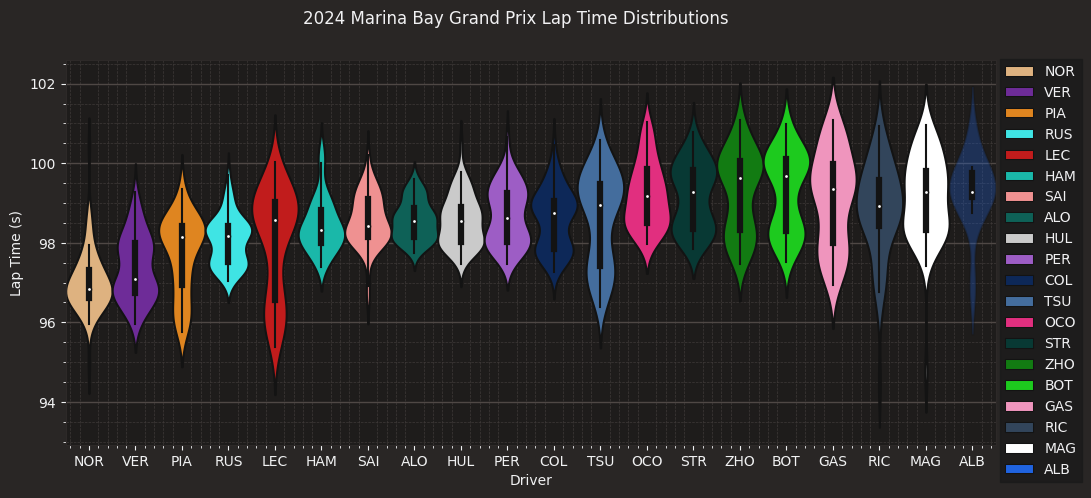

In [12]:
plot_driver_laptime_distribution(all_driver_laps, finishing_order, driver_colors)

In [13]:
def plot_driver_laptime_distribution_by_tire(driver_laps, finishing_order, driver_colors):
    fig, ax = plt.subplots(figsize=(12, 5))
    all_driver_laps["LapTime(s)"] = all_driver_laps["LapTime"].dt.total_seconds()
    """ violin= sns.violinplot(data=driver_laps,
                x="Driver",
                y="LapTime(s)",
                width=1,
                dodge=False,
                hue="Driver",
                order=finishing_order,
                hue_order=finishing_order,
                palette=driver_colors,
                whiskerprops=dict(color='white'),
                capprops=dict(color='white')
                ) """
    # Identify location of correct violins
    """ for i, violin_collection in enumerate(violin.collections):
        print("Violin", i+1, ":", violin_collection)
        if i%2==0:
            violin.collections[i].set_alpha(0) """

    # Show spread of laptimes by tire type
    sns.swarmplot(data=driver_laps,
                x="Driver",
                y="LapTime(s)",
                order=finishing_order,
                hue="Compound",
                palette=fastf1.plotting.COMPOUND_COLORS,
                hue_order=["SOFT", "MEDIUM", "HARD"],
                linewidth=0,
                size=3,
                )

    # Drivers who DNF'd have reduced opacity
    """ for d in range(len(finishing_order)):
        drvr=finishing_order[d]
        n = np.where(results['Abbreviation']==drvr)[0][0]
        if results['ClassifiedPosition'][d]=='R':
            #print(f"{d} {results['Abbreviation'][d]}")
            violin.collections[2*d].set_alpha(0.3) """

    ax.set_xlabel("Driver")
    ax.set_ylabel("Lap Time (s)")
    plt.suptitle(f"2024 {session_name} Grand Prix Lap Time Distributions")
    ax.legend(bbox_to_anchor=(1.10, 1.02))
    plt.show()

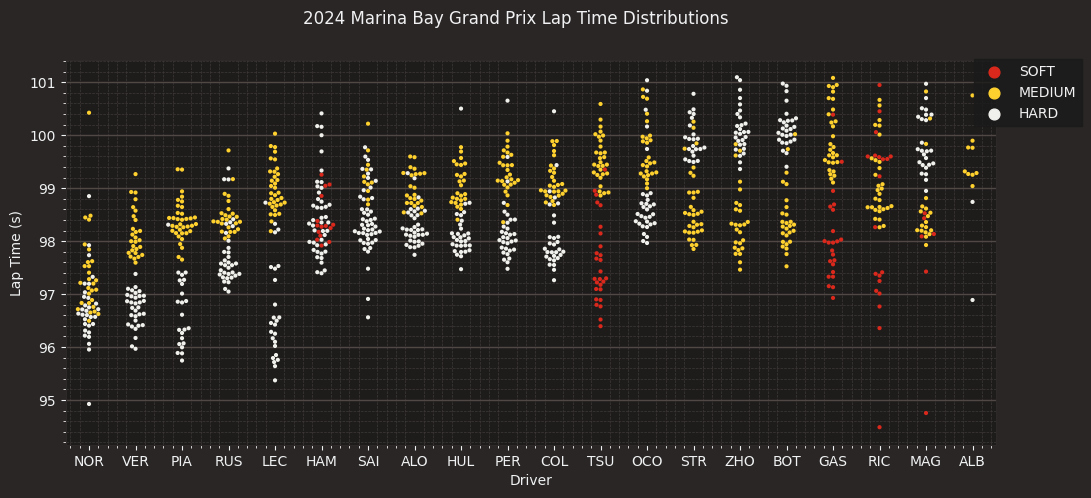

In [14]:
plot_driver_laptime_distribution_by_tire(all_driver_laps, finishing_order, driver_colors)

In [15]:
fastf1.Cache.clear_cache()